In [1]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_context("notebook")
sns.set_style("dark")

In [4]:
use_example = False
if use_example:
    with open("example-real-data.json", "rb") as f:
        old_raw_data = json.load(f)
else:
    old_raw_data = {"data": []}
    files = os.listdir("./data/")
    for file in files:
        if file.endswith(".json"):
            with open(f"data/{file}", "r") as f:
                match_data = json.load(f)
                match_ts = file.replace(".json", "")
                if len(match_data["data"]) < 1000:
                    continue
                old_raw_data["data"] += [{**el, "match_ts": match_ts} for el in match_data["data"]]

In [5]:
len(old_raw_data["data"])

22896

## Loading raw data from analytics system

In [6]:
is_veteran_regex = r'\w+\-\w*V\w*'

In [7]:
show_outliers = False
share_x = 'all'

In [8]:
raw_data = []

for el in old_raw_data["data"]:
    # Value
    if "value" in el:
        el["value"] = float(el["value"])

    # Unique ts of match
    if "i" in el:
        el["i"] = el["i"] + "-" + el["match_ts"]
    if "t" in el:
        el["t"] = el["t"] + "-" + el["match_ts"]
    if "ips" in el:
        el["ips"] = el["ips"] + "-" + el["match_ts"]
    if "tps" in el:
        el["tps"] = el["tps"] + "-" + el["match_ts"]

    # Classes
    if "il" in el and "if" in el:
        el["i-faction-class"] = el["if"] + "-" + el["il"]
        el["i-is-veteran"] = bool(re.search(is_veteran_regex, el["i-faction-class"]))

    if "tl" in el and "tf" in el:
        el["t-faction-class"] = el["tf"] + "-" + el["tl"]
        el["t-is-veteran"] = bool(re.search(is_veteran_regex, el["t-faction-class"]))

    # Instigator coords
    if "ic" in el:
        el["ic_x"] = float(el["ic"].split(" ")[0].split("=")[1])
    if "ic" in el:
        el["ic_y"] = float(el["ic"].split(" ")[1].split("=")[1])

    # Target coords
    if "tc" in el:
        el["tc_x"] = float(el["tc"].split(" ")[0].split("=")[1])
    if "tc" in el:
        el["tc_y"] = float(el["tc"].split(" ")[1].split("=")[1])

    raw_data.append(el)

## Analyzing damage (per pawn, per class)

In [9]:
damage_df = pd.DataFrame([el for el in raw_data if el["Type"] == "Damage"])

In [125]:
# Removing friendly fire when analyzing damage
damage_df = damage_df[damage_df["if"] != damage_df["tf"]]

# Leave only damage from characters to characters
damage_df = damage_df[damage_df['i'].str.startswith("CH_")]
damage_df = damage_df[damage_df['t'].str.startswith("CH_")]

In [11]:
damage_df.head()

,value,i,t,ips,tps,il,tl,if,tf,ic,...,Type,match_ts,i-faction-class,i-is-veteran,t-faction-class,t-is-veteran,ic_x,ic_y,tc_x,tc_y
0,20.0,CH_2147446280-2023-09-28T18-30-24.027793,CH_2147447461-2023-09-28T18-30-24.027793,PS_2147449614-2023-09-28T18-30-24.027793,PS_2147471837-2023-09-28T18-30-24.027793,HboS,TacS,CSM,LSM,X=51079.837 Y=29148.345 Z=-4459.713,...,Damage,2023-09-28T18-30-24.027793,CSM-HboS,False,LSM-TacS,False,51079.837,29148.345,56350.857,27681.017
1,20.0,CH_2147446280-2023-09-28T18-30-24.027793,CH_2147447461-2023-09-28T18-30-24.027793,PS_2147449614-2023-09-28T18-30-24.027793,PS_2147471837-2023-09-28T18-30-24.027793,HboS,TacS,CSM,LSM,X=51046.594 Y=28667.714 Z=-5662.335,...,Damage,2023-09-28T18-30-24.027793,CSM-HboS,False,LSM-TacS,False,51046.594,28667.714,55723.916,30893.533
2,20.0,CH_2147446280-2023-09-28T18-30-24.027793,CH_2147447461-2023-09-28T18-30-24.027793,PS_2147449614-2023-09-28T18-30-24.027793,PS_2147471837-2023-09-28T18-30-24.027793,HboS,TacS,CSM,LSM,X=51046.594 Y=28667.714 Z=-5662.335,...,Damage,2023-09-28T18-30-24.027793,CSM-HboS,False,LSM-TacS,False,51046.594,28667.714,55705.413,31008.169
3,20.0,CH_2147446280-2023-09-28T18-30-24.027793,CH_2147447461-2023-09-28T18-30-24.027793,PS_2147449614-2023-09-28T18-30-24.027793,PS_2147471837-2023-09-28T18-30-24.027793,HboS,TacS,CSM,LSM,X=54234.603 Y=29929.099 Z=-5612.713,...,Damage,2023-09-28T18-30-24.027793,CSM-HboS,False,LSM-TacS,False,54234.603,29929.099,56990.912,34883.034
4,20.0,CH_2147446280-2023-09-28T18-30-24.027793,CH_2147447461-2023-09-28T18-30-24.027793,PS_2147449614-2023-09-28T18-30-24.027793,PS_2147471837-2023-09-28T18-30-24.027793,HboS,TacS,CSM,LSM,X=54263.730 Y=29936.583 Z=-5612.713,...,Damage,2023-09-28T18-30-24.027793,CSM-HboS,False,LSM-TacS,False,54263.730,29936.583,56952.712,34906.876


In [124]:
damage_per_pawn = damage_df.groupby(["i"]).agg(
    damage_per_life=('value', 'sum'),
    loadout=('i-faction-class', 'first'),
    is_veteran=('i-is-veteran', 'first'),
    faction=('if', 'first')
)

In [13]:
damage_per_life_for_classes = damage_per_pawn.sort_values(by='loadout').groupby("loadout").agg(
    mean_damage_per_life=('damage_per_life', 'mean'),
    std_damage_per_life=('damage_per_life', 'std')
)
damage_per_life_for_classes

,mean_damage_per_life,std_damage_per_life
loadout,,
CSM-AucV,730.574596,442.655185
CSM-HboS,701.935118,764.134950
CSM-JpaS,638.181872,615.162968
CSM-JpaVA,534.174593,22.380505
CSM-MelS,310.403847,284.148975
CSM-MelV,1440.797400,NaN
CSM-PcaS,721.378380,713.670383
CSM-SupS,458.596030,473.732052
CSM-TacS,538.803990,546.735862


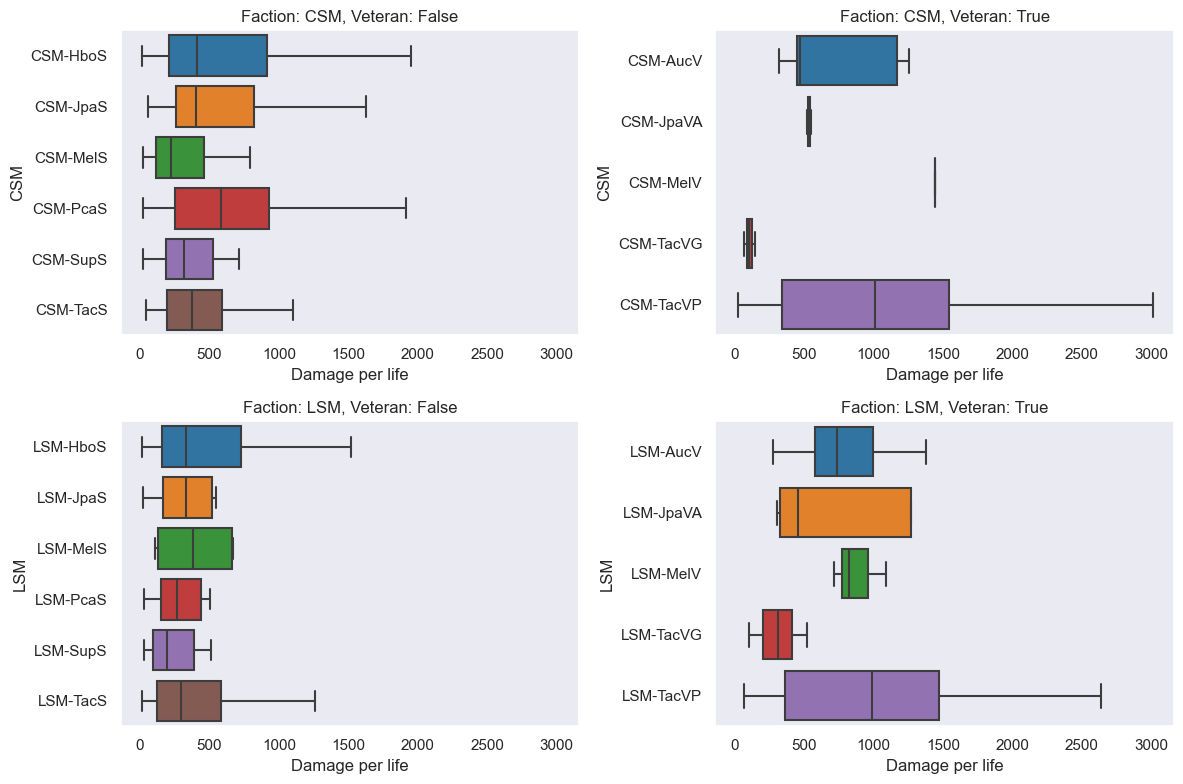

In [14]:
# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(damage_per_pawn['faction'].unique()),
    ncols=len(damage_per_pawn['is_veteran'].unique()),
    figsize=(12, 8),
    sharex=share_x
)

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(damage_per_pawn.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
    sns.boxplot(x='damage_per_life', y='loadout', data=subset, ax=ax, orient='h', showfliers=show_outliers)

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('Damage per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing XP (per pawn, per class and action)

In [21]:
xp_df = pd.DataFrame([el for el in raw_data if el["Type"] == "XP"])

# Leave only XP to characters
xp_df = xp_df[xp_df['t'].str.startswith("CH_")]

xp_df.head()

,t,value,tps,tf,tl,tc,action,Type,match_ts,t-faction-class,t-is-veteran,tc_x,tc_y
2,CH_2147447461-2023-09-28T18-30-24.027793,400.0,PS_2147471837-2023-09-28T18-30-24.027793,LSM,TacS,X=44782.712 Y=32740.921 Z=-4459.713,Started capture,XP,2023-09-28T18-30-24.027793,LSM-TacS,False,44782.712,32740.921
3,CH_2147442392-2023-09-28T18-30-24.027793,50.0,PS_2147479940-2023-09-28T18-30-24.027793,CSM,JpaS,X=59224.313 Y=29576.522 Z=-5659.957,Assist,XP,2023-09-28T18-30-24.027793,CSM-JpaS,False,59224.313,29576.522
4,CH_2147444707-2023-09-28T18-30-24.027793,100.0,PS_2147479638-2023-09-28T18-30-24.027793,CSM,SupS,X=59740.960 Y=29501.130 Z=-5663.320,Enemy down,XP,2023-09-28T18-30-24.027793,CSM-SupS,False,59740.960,29501.130
5,CH_2147444707-2023-09-28T18-30-24.027793,50.0,PS_2147479638-2023-09-28T18-30-24.027793,CSM,SupS,X=59742.420 Y=29511.040 Z=-5663.320,Enemy finished,XP,2023-09-28T18-30-24.027793,CSM-SupS,False,59742.420,29511.040
6,CH_2147446280-2023-09-28T18-30-24.027793,50.0,PS_2147449614-2023-09-28T18-30-24.027793,CSM,HboS,X=49303.187 Y=29813.188 Z=-4459.713,Assist,XP,2023-09-28T18-30-24.027793,CSM-HboS,False,49303.187,29813.188


In [122]:
xp_per_pawn_and_action = xp_df.groupby(["t", "action"]).agg(
    xp_per_life=('value', 'sum'),
    loadout=('t-faction-class', 'first'),
    is_veteran=('t-is-veteran', 'first'),
    faction=('tf', 'first')
)

In [121]:
xp_per_pawn = xp_df.groupby("t").agg(
    xp_per_life=('value', 'sum'),
    loadout=('t-faction-class', 'first'),
    is_veteran=('t-is-veteran', 'first'),
    faction=('tf', 'first')
)

In [120]:
xp_per_life_for_class_and_action = xp_per_pawn_and_action.groupby(["loadout", "action"]).agg(
    mean_xp_per_life=('xp_per_life', 'mean'),
    std_xp_per_life=('xp_per_life', 'std'),
    is_veteran=('is_veteran', 'first'),
    faction=('faction', 'first')
)

In [119]:
xp_per_life_for_class = xp_per_pawn.groupby(["loadout"]).agg(
    mean_xp_per_life=('xp_per_life', 'mean'),
    std_xp_per_life=('xp_per_life', 'std')
)
xp_per_life_for_class

,mean_xp_per_life,std_xp_per_life
loadout,,
CSM-AucV,243.000000,192.308779
CSM-HboS,446.035714,611.114064
CSM-JpaS,475.240000,581.376548
CSM-JpaVA,150.000000,70.710678
CSM-MelS,515.909091,464.293207
CSM-MelV,583.000000,NaN
CSM-PcaS,339.590909,520.960576
CSM-SupS,468.625000,444.543421
CSM-TacS,590.468750,597.254883


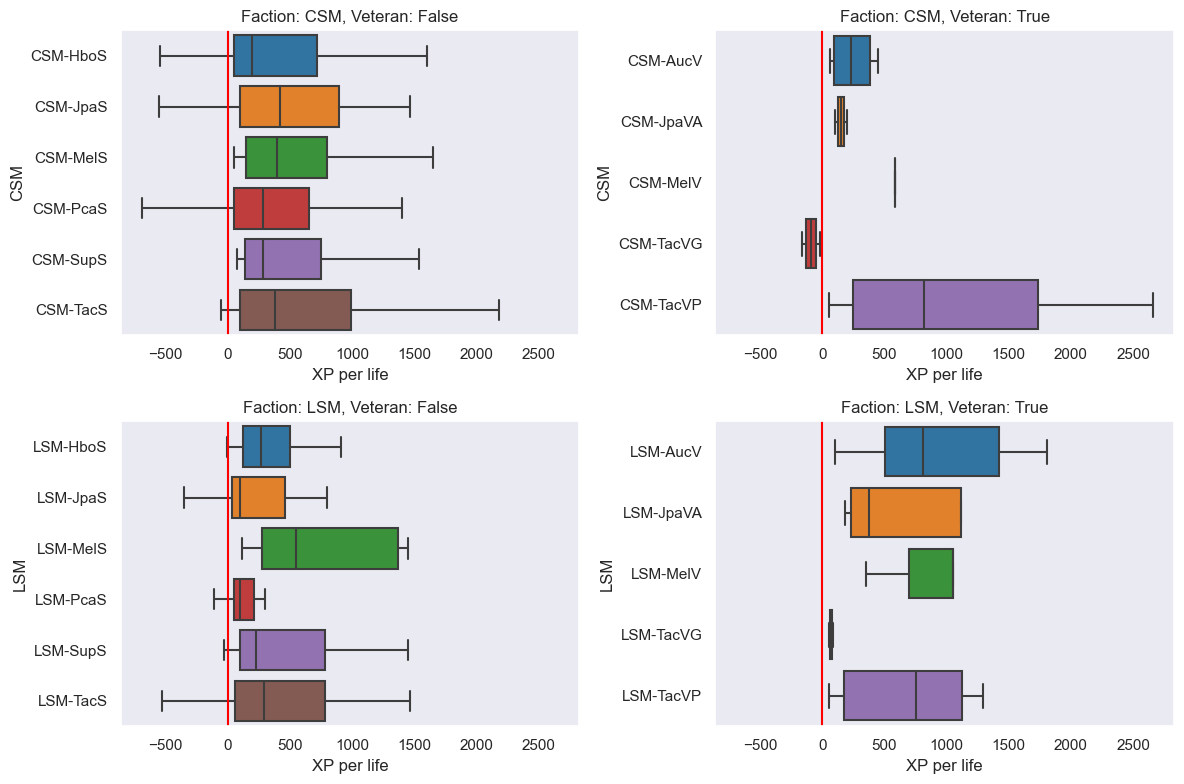

In [99]:
# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(xp_per_pawn['faction'].unique()),
    ncols=len(xp_per_pawn['is_veteran'].unique()),
    figsize=(12, 8),
    sharex=share_x
)

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(xp_per_pawn.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
    sns.boxplot(x='xp_per_life', y='loadout', data=subset, ax=ax, orient='h', showfliers=show_outliers)

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('XP per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)

    ax.axvline(x=0, color='red')


# Adjust layout
plt.tight_layout()
plt.show()

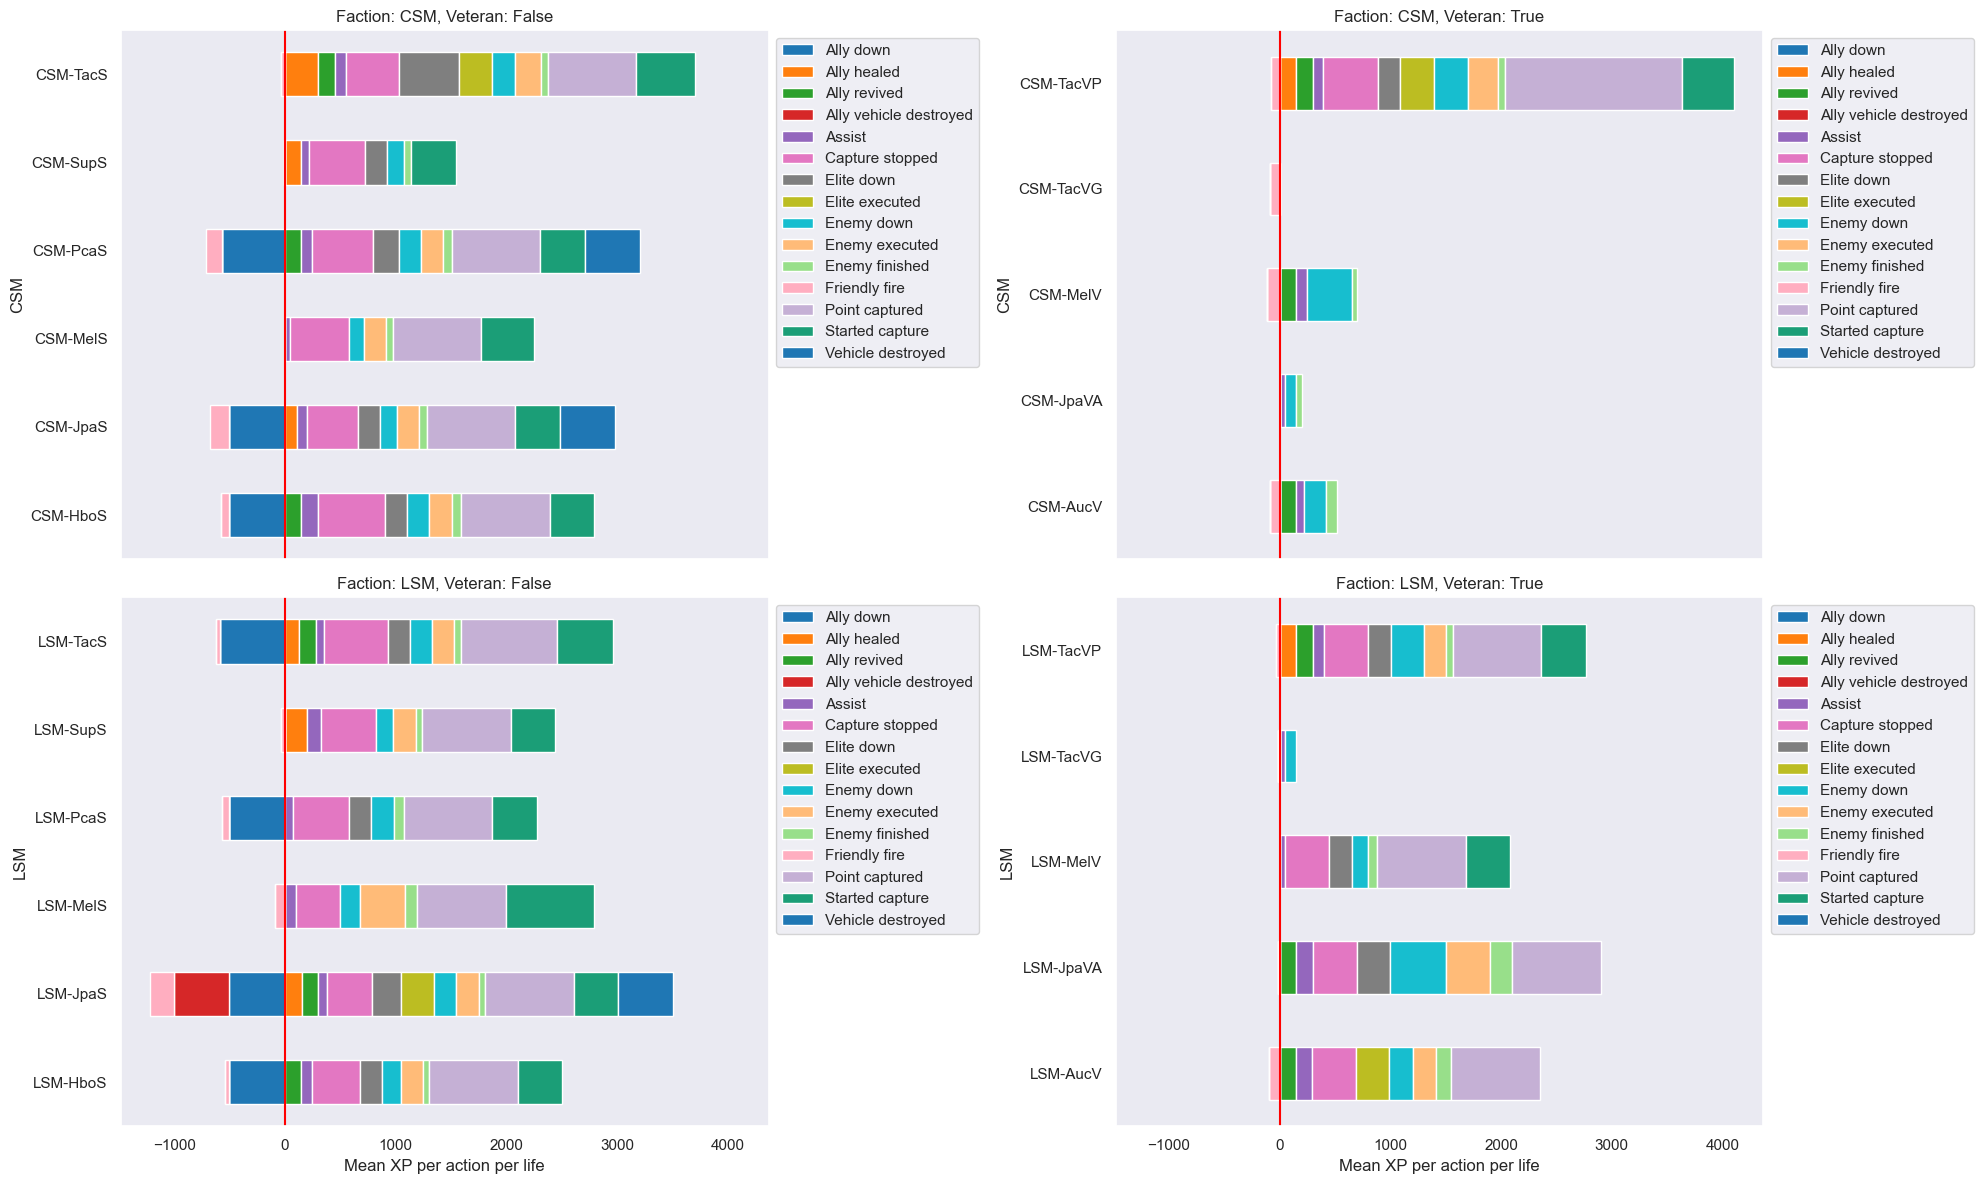

In [111]:
# Create a pivot table to reshape the data for plotting
pivot_xp_per_life_for_class_and_action = xp_per_life_for_class_and_action.reset_index()
pivot_xp_per_life_for_class_and_action = pivot_xp_per_life_for_class_and_action.pivot(index=['loadout', 'faction', 'is_veteran'], columns='action',
                                                                                      values='mean_xp_per_life')
pivot_xp_per_life_for_class_and_action = pivot_xp_per_life_for_class_and_action.reset_index().set_index("loadout")

# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(xp_per_pawn['faction'].unique()),
    ncols=len(xp_per_pawn['is_veteran'].unique()),
    figsize=(24, 16),
    sharex=share_x
)

# Define a custom color palette
custom_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Yellow-Green
    '#17becf',  # Cyan
    '#ffbb78',  # Light Orange
    '#98df8a',  # Light Green
    '#ffaec0',  # Light Pink
    '#c5b0d5',  # Light Purple
    '#1b9e77',  # Dark Green
]

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(pivot_xp_per_life_for_class_and_action.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
    subset = subset.drop(["faction", "is_veteran"], axis=1)

    # Create a rotated stacked barplot with the custom color palette
    subset.plot(kind='barh', stacked=True, figsize=(20, 12), color=custom_colors, ax=ax)

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('Mean XP per action per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)
    ax.legend(bbox_to_anchor=(1, 1))

    ax.axvline(x=0, color='red')

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing KS ratios

In [112]:
kills_df = xp_df[xp_df["action"] == "Enemy down"]
kills_df.head()

,t,value,tps,tf,tl,tc,action,Type,match_ts,t-faction-class,t-is-veteran,tc_x,tc_y
4,CH_2147444707-2023-09-28T18-30-24.027793,100.0,PS_2147479638-2023-09-28T18-30-24.027793,CSM,SupS,X=59740.960 Y=29501.130 Z=-5663.320,Enemy down,XP,2023-09-28T18-30-24.027793,CSM-SupS,False,59740.960,29501.130
7,CH_2147447130-2023-09-28T18-30-24.027793,100.0,PS_2147478386-2023-09-28T18-30-24.027793,CSM,SupS,X=46697.310 Y=29633.390 Z=-4459.710,Enemy down,XP,2023-09-28T18-30-24.027793,CSM-SupS,False,46697.310,29633.390
11,CH_2147442392-2023-09-28T18-30-24.027793,100.0,PS_2147479940-2023-09-28T18-30-24.027793,CSM,JpaS,X=54281.110 Y=25800.480 Z=-5656.430,Enemy down,XP,2023-09-28T18-30-24.027793,CSM-JpaS,False,54281.110,25800.480
17,CH_2147440061-2023-09-28T18-30-24.027793,100.0,PS_2147479963-2023-09-28T18-30-24.027793,CSM,HboS,X=40869.104 Y=30666.154 Z=-5157.491,Enemy down,XP,2023-09-28T18-30-24.027793,CSM-HboS,False,40869.104,30666.154
29,CH_2147437970-2023-09-28T18-30-24.027793,100.0,PS_2147478498-2023-09-28T18-30-24.027793,CSM,MelS,X=44341.690 Y=30393.860 Z=-5612.710,Enemy down,XP,2023-09-28T18-30-24.027793,CSM-MelS,False,44341.690,30393.860


In [114]:
kills_per_pawn = kills_df.groupby(["t"]).agg(
    kill_count=('t', 'count'),
    loadout=('t-faction-class', 'first'),
    faction=('tf', 'first'),
    is_veteran=('t-is-veteran', 'first')
)
kills_per_pawn.head()

,kill_count,loadout,faction,is_veteran
t,,,,
CH_2146997203-2023-09-28T20-10-31.299829,1,LSM-PcaS,LSM,False
CH_2146998499-2023-09-28T20-10-31.299829,1,CSM-JpaS,CSM,False
CH_2147002824-2023-09-28T20-10-31.299829,1,LSM-PcaS,LSM,False
CH_2147003898-2023-09-28T20-10-31.299829,3,CSM-TacVP,CSM,True
CH_2147006279-2023-09-28T20-10-31.299829,1,LSM-TacS,LSM,False


In [118]:
kills_per_life_for_classes = kills_per_pawn.groupby("loadout").agg(
    mean_kills_per_life=('kill_count', 'mean'),
    std_kills_per_life=('kill_count', 'std')
)
kills_per_life_for_classes

,mean_kills_per_life,std_kills_per_life
loadout,,
CSM-AucV,2.000000,1.000000
CSM-HboS,2.052632,1.844603
CSM-JpaS,1.555556,0.855585
CSM-JpaVA,1.000000,NaN
CSM-MelS,1.300000,0.674949
CSM-MelV,4.000000,NaN
CSM-PcaS,2.000000,1.683251
CSM-SupS,1.500000,1.000000
CSM-TacS,2.076923,1.595794


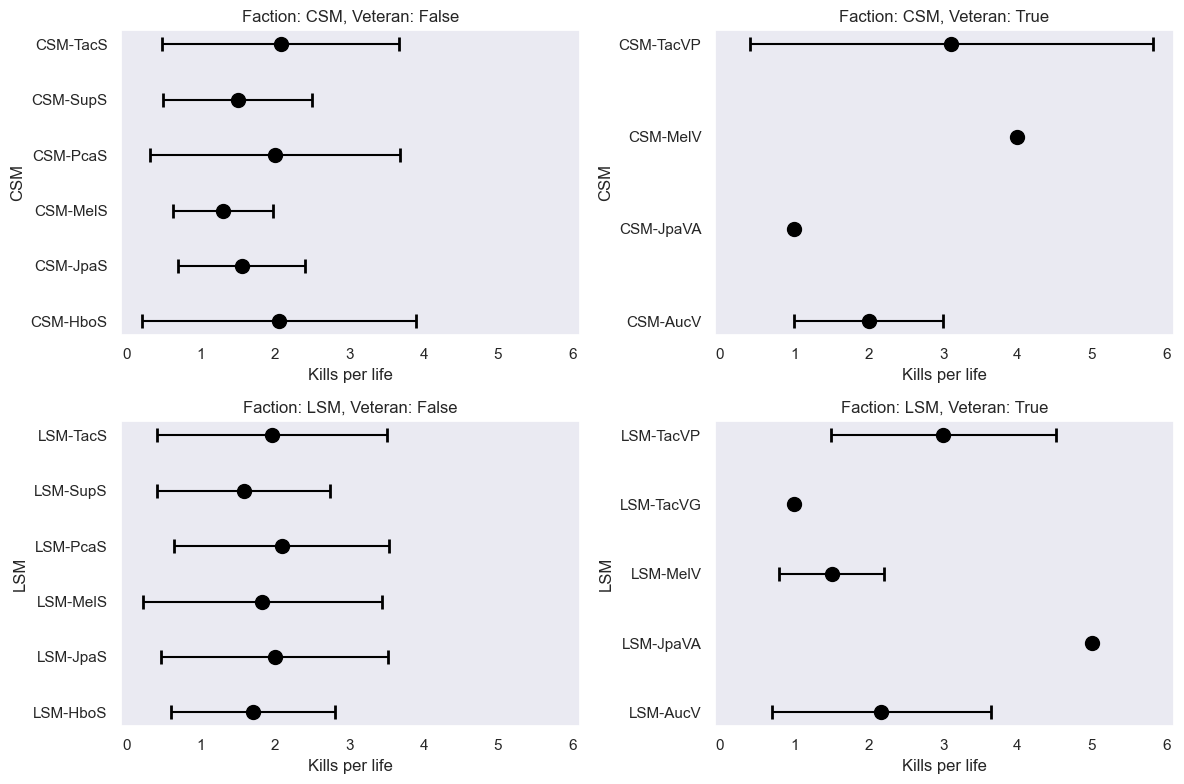

In [117]:
# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(kills_per_pawn['faction'].unique()),
    ncols=len(kills_per_pawn['is_veteran'].unique()),
    figsize=(12, 8),
    sharex=share_x
)

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(kills_per_pawn.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'

    grouped = subset.groupby('loadout')['kill_count']
    means = grouped.mean()
    stds = grouped.std()

    # Create a horizontal scatter plot for means
    ax.scatter(means, means.index, color='black', label='Mean', s=100, marker='o')  # Adjust the 's' parameter for size

    # Create vertical bars for standard deviation
    for i, (mean_val, std_val) in enumerate(zip(means, stds)):
        ax.errorbar(mean_val, i, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('Kills per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing class frequencies

In [126]:
spawn_df = pd.DataFrame([el for el in raw_data if el["Type"] == "Spawn"])

In [127]:
class_spawns = spawn_df["t-faction-class"].value_counts()

<Axes: title={'center': 'Classes spawn frequency'}, ylabel='t-faction-class'>

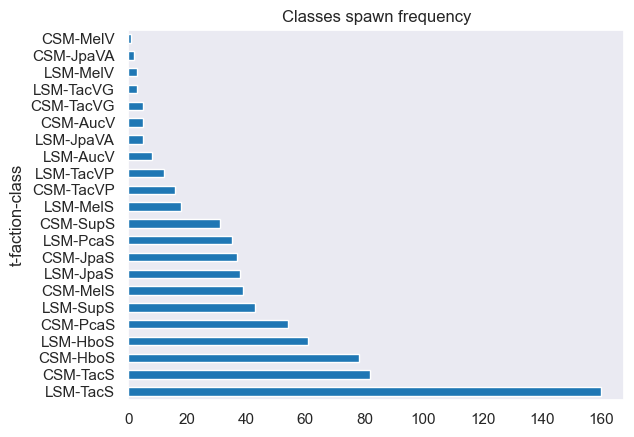

In [129]:
class_spawns.plot.barh(title="Classes spawn frequency")

## Heatmaps

### Damage dealers

In [68]:
x_points = list(damage_df["ic_x"])
y_points = list(damage_df["ic_y"])

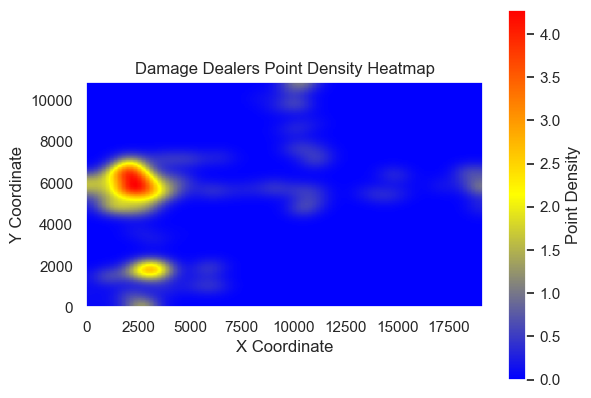

In [83]:
from matplotlib.colors import LinearSegmentedColormap

# Create a 2D histogram to represent point density
heatmap, xedges, yedges = np.histogram2d(x_points, y_points, bins=100)

# Smooth the heatmap using Gaussian convolution
from scipy.ndimage import gaussian_filter

heatmap = gaussian_filter(heatmap, sigma=3)

# Define a custom colormap (blue, yellow, red)
colors = [(0, 'blue'), (0.5, 'yellow'), (1, 'red')]
custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

# Create the heatmap plot
plt.imshow(heatmap.T, origin='lower', extent=[0, xedges.max(), 0, yedges.max()], cmap=custom_cmap)
plt.colorbar(label='Point Density')  # Add a colorbar for reference
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Damage Dealers Point Density Heatmap')

plt.show()